In [1]:
from function import *
from data_preparation import *
from evaluation import *

from openpyxl import Workbook
import pandas as pd
import numpy as np
import operator

from rdkit import Chem
from rdkit.Chem import AllChem

# Pre-prepare Data (Data Transformation)

In [2]:
# transform_data(output_file_name='../dataset/keck_complete.csv')

# Analysis

In [3]:
complete_df = pd.read_csv('../dataset/keck_complete.csv')

print complete_df.dtypes

Molecule                   object
SMILES                     object
Fingerprints               object
Keck_Pria_AS_Retest         int64
Keck_Pria_FP_data           int64
Keck_Pria_Continuous      float64
Keck_RMI_cdd              float64
FP counts % inhibition    float64
dtype: object


In [4]:
cnt_pria_retest = 0
cnt_pria_fp = 0
cnt_rmi_cdd = 0

cnt_dict = {}
for ix, row in complete_df.iterrows():
    cnt = 0
    if row['Keck_Pria_AS_Retest'] == 1:
        cnt_pria_retest += 1
        cnt += 1
    if row['Keck_Pria_FP_data'] == 1:
        cnt_pria_fp += 1
        cnt += 1
    if row['Keck_RMI_cdd'] == 1:
        cnt_rmi_cdd += 1
        cnt += 1
    if cnt not in cnt_dict.keys():
        cnt_dict[cnt] = 0
    cnt_dict[cnt] += 1

print 'pria retest active: {}\tpria fp active: {}\trmi cdd active: {}'.format(cnt_pria_retest, cnt_pria_fp, cnt_rmi_cdd)
print cnt_dict


print
analysis(complete_df)

pria retest active: 79	pria fp active: 24	rmi cdd active: 230
{0: 72094, 1: 325, 2: 4}

retest: 0, fp: 0, rmi: 0 	--- 49489
retest: 0, fp: 0, rmi: nan 	--- 22605
retest: 0, fp: 1, rmi: 0 	--- 19
retest: 0, fp: 1, rmi: 1 	--- 3
retest: 1, fp: 0, rmi: 0 	--- 58
retest: 1, fp: 0, rmi: nan 	--- 20
retest: 0, fp: 1, rmi: nan 	--- 1
retest: 0, fp: 0, rmi: 1 	--- 227
retest: 1, fp: 1, rmi: nan 	--- 1


# Split data into k-fold

In [5]:
k = 3
directory = '../dataset/fixed_dataset/fold_{}/'.format(k)
file_list = []
for i in range(k):
    file_list.append('file_{}.csv'.format(i))
# greedy_multi_splitting(complete_df, k, directory=directory, file_list=file_list)

In [6]:
k = 4
directory = '../dataset/fixed_dataset/fold_{}/'.format(k)
file_list = []
for i in range(k):
    file_list.append('file_{}.csv'.format(i))
# greedy_multi_splitting(complete_df, k, directory=directory, file_list=file_list)

In [7]:
k = 5
directory = '../dataset/fixed_dataset/fold_{}/'.format(k)
file_list = []
for i in range(k):
    file_list.append('file_{}.csv'.format(i))
# greedy_multi_splitting(complete_df, k, directory=directory, file_list=file_list)

# Merge data from splitting folds to form training and testing

In [8]:
dtype_list = {'Molecule': np.str,
              'SMILES':np.str,
              'Fingerprints': np.str,
              'Keck_Pria_AS_Retest': np.int64,
              'Keck_Pria_FP_data': np.int64,
              'Keck_Pria_Continuous': np.float64,
              'Keck_RMI_cdd': np.float64}
output_file_list = [directory + f_ for f_ in file_list]
print output_file_list[:4]
train_pd = read_merged_data(output_file_list[:4])
print output_file_list[4]
test_pd = read_merged_data([output_file_list[4]])

['../dataset/fixed_dataset/fold_5/file_0.csv', '../dataset/fixed_dataset/fold_5/file_1.csv', '../dataset/fixed_dataset/fold_5/file_2.csv', '../dataset/fixed_dataset/fold_5/file_3.csv']
../dataset/fixed_dataset/fold_5/file_4.csv


In [9]:
print 'This is training set'
analysis(train_pd)
print
print 'This is test set'
analysis(test_pd)

This is training set
retest: 0, fp: 0, rmi: 0 	--- 39591
retest: 0, fp: 0, rmi: nan 	--- 18084
retest: 1, fp: 0, rmi: nan 	--- 16
retest: 0, fp: 1, rmi: 1 	--- 2
retest: 1, fp: 0, rmi: 0 	--- 47
retest: 0, fp: 0, rmi: 1 	--- 181
retest: 0, fp: 1, rmi: nan 	--- 1
retest: 0, fp: 1, rmi: 0 	--- 15

This is test set
retest: 0, fp: 0, rmi: 0 	--- 9898
retest: 0, fp: 0, rmi: nan 	--- 4521
retest: 1, fp: 0, rmi: nan 	--- 4
retest: 0, fp: 1, rmi: 1 	--- 1
retest: 1, fp: 0, rmi: 0 	--- 11
retest: 0, fp: 0, rmi: 1 	--- 46
retest: 0, fp: 1, rmi: 0 	--- 4
retest: 1, fp: 1, rmi: nan 	--- 1


# Test feature- and label- extraction

In [10]:
print train_pd.dtypes

X_train, y_train = extract_feature_and_label(train_pd,
                                             feature_name='Fingerprints',
                                             label_name_list=['Keck_Pria_AS_Retest', 'Keck_Pria_FP_data'])
X_test, y_test = extract_feature_and_label(test_pd,
                                           feature_name='Fingerprints',
                                           label_name_list=['Keck_Pria_AS_Retest', 'Keck_Pria_FP_data'])

Molecule                   object
SMILES                     object
Fingerprints               object
Keck_Pria_AS_Retest         int64
Keck_Pria_FP_data           int64
Keck_Pria_Continuous      float64
Keck_RMI_cdd              float64
FP counts % inhibition    float64
dtype: object
(57937, 2)
(14486, 2)


# Test Single Classification with Simple NN

## Test Label 'Keck_Pria_AS_Retest'

In [11]:
from sklearn.cross_validation import StratifiedShuffleSplit

X_train, y_train = extract_feature_and_label(train_pd,
                                             feature_name='Fingerprints',
                                             label_name_list=['Keck_Pria_AS_Retest'])
X_test, y_test = extract_feature_and_label(test_pd,
                                           feature_name='Fingerprints',
                                           label_name_list=['Keck_Pria_AS_Retest'])
cross_validation_split = StratifiedShuffleSplit(y_train, 1, test_size=0.15, random_state=1)
for t_index, val_index in cross_validation_split:
    X_t, X_val = X_train[t_index], X_train[val_index]
    y_t, y_val = y_train[t_index], y_train[val_index]
print 'done data preparation'

(57937, 1)
(14486, 1)
done data preparation


In [12]:
from single_task import *

config_json_file = '../json/classification.json'
PMTNN_weight_file = 'temp.h5'
task = single_task(config_json_file=config_json_file)
task.train_and_predict(X_t, y_t, X_val, y_val, X_test, y_test, PMTNN_weight_file)

Using Theano backend.
Using gpu device 0: Tesla K40m (CNMeM is disabled, CuDNN 4004)


Epoch 1/200
Precision Train: 0.004099 ---- Precision Val: 0.001965
AUC Train: 0.741446 ---- AUC Val: 0.713891

Epoch 2/200
Precision Train: 0.034350 ---- Precision Val: 0.004341
AUC Train: 0.853858 ---- AUC Val: 0.851685

Epoch 3/200
Precision Train: 0.019165 ---- Precision Val: 0.008489
AUC Train: 0.901465 ---- AUC Val: 0.866723

Epoch 4/200
Precision Train: 0.076085 ---- Precision Val: 0.004118
AUC Train: 0.927588 ---- AUC Val: 0.790870

Epoch 5/200
Precision Train: 0.155663 ---- Precision Val: 0.006573
AUC Train: 0.964227 ---- AUC Val: 0.818795

Epoch 6/200
Precision Train: 0.271452 ---- Precision Val: 0.008634
AUC Train: 0.970398 ---- AUC Val: 0.808531

Epoch 7/200
Precision Train: 0.489832 ---- Precision Val: 0.007692
AUC Train: 0.979260 ---- AUC Val: 0.865315

Epoch 8/200
Precision Train: 0.561526 ---- Precision Val: 0.031116
AUC Train: 0.984250 ---- AUC Val: 0.887328

Epoch 9/200
Precision Train: 0.748556 ---- Precision Val: 0.035069
AUC Train: 0.995102 ---- AUC Val: 0.847385

E

# Plot EF and EF-Max graph

In [13]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (25.0, 10.0)

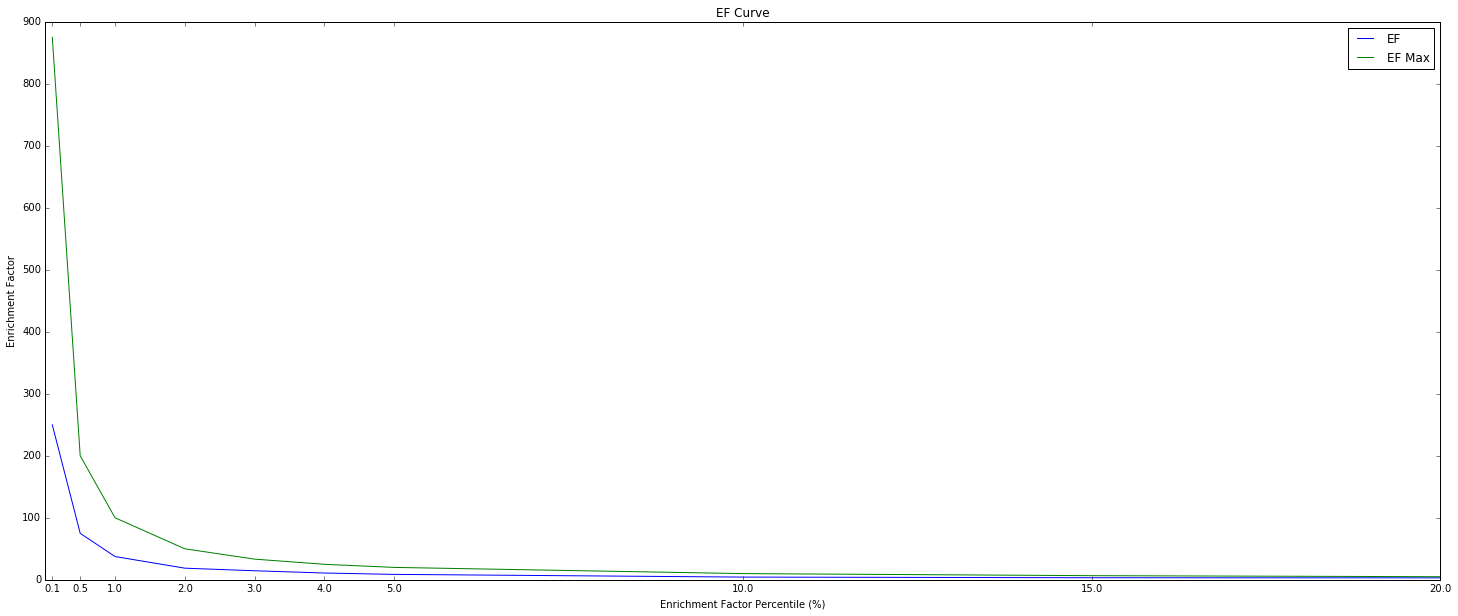

In [14]:
def plot_EF_score_with_existing_model(X_test, y_test, file_path, EF_ratio=0.1):
    model = task.setup_model()
    model.load_weights(file_path)
    y_pred_on_test = model.predict(X_test)
    EF_ratio_list = [0.1, 0.5, 1, 2, 3, 4, 5, 10, 15, 20]
    EF_ratio_list = np.array(EF_ratio_list) / 100.0
    
    ef_values = []
    ef_max_values = []
    for EF_ratio in EF_ratio_list:
        n_actives, ef, ef_max = enrichment_factor_single(y_test, y_pred_on_test, EF_ratio)
        ef_values.append(ef)
        ef_max_values.append(ef_max)
    
    x_axis = EF_ratio_list
    y_axis = np.array(ef_values)
    plt.plot(x_axis, y_axis)
    
    x_axis = EF_ratio_list
    y_axis = np.array(ef_max_values)
    plt.plot(x_axis, y_axis)
    
    plt.legend(['EF', 'EF Max'])
    
    plt.xticks(EF_ratio_list, [str(val*100) for val in EF_ratio_list])
    plt.xlabel('Enrichment Factor Percentile (%)')
    plt.ylabel('Enrichment Factor')
    plt.title('EF Curve')
    plt.show()
    return

plot_EF_score_with_existing_model(X_test, y_test, PMTNN_weight_file)

## Test Label 'Keck_Pria_AS_Retest'

In [15]:
from sklearn.cross_validation import StratifiedShuffleSplit

X_train, y_train = extract_feature_and_label(train_pd,
                                             feature_name='Fingerprints',
                                             label_name_list=['Keck_Pria_FP_data'])
X_test, y_test = extract_feature_and_label(test_pd,
                                           feature_name='Fingerprints',
                                           label_name_list=['Keck_Pria_FP_data'])
cross_validation_split = StratifiedShuffleSplit(y_train, 1, test_size=0.15, random_state=1)
for t_index, val_index in cross_validation_split:
    X_t, X_val = X_train[t_index], X_train[val_index]
    y_t, y_val = y_train[t_index], y_train[val_index]
print 'done data preparation'

(57937, 1)
(14486, 1)
done data preparation


In [16]:
from single_task import *

config_json_file = '../json/classification.json'
PMTNN_weight_file = 'temp.h5'
task = single_task(config_json_file=config_json_file)
task.train_and_predict(X_t, y_t, X_val, y_val, X_test, y_test, PMTNN_weight_file)

Epoch 1/200
Precision Train: 0.000317 ---- Precision Val: 0.000197
AUC Train: 0.523340 ---- AUC Val: 0.193255

Epoch 2/200
Precision Train: 0.000750 ---- Precision Val: 0.000238
AUC Train: 0.699550 ---- AUC Val: 0.330609

Epoch 3/200
Precision Train: 0.000909 ---- Precision Val: 0.000256
AUC Train: 0.740050 ---- AUC Val: 0.370127

Epoch 4/200
Precision Train: 0.002057 ---- Precision Val: 0.000266
AUC Train: 0.847538 ---- AUC Val: 0.402739

Epoch 5/200
Precision Train: 0.004862 ---- Precision Val: 0.000288
AUC Train: 0.884042 ---- AUC Val: 0.418930

Epoch 6/200
Precision Train: 0.011444 ---- Precision Val: 0.000222
AUC Train: 0.941894 ---- AUC Val: 0.281423

Epoch 7/200
Precision Train: 0.016006 ---- Precision Val: 0.000225
AUC Train: 0.911929 ---- AUC Val: 0.279121

Epoch 8/200
Precision Train: 0.031027 ---- Precision Val: 0.000208
AUC Train: 0.971081 ---- AUC Val: 0.238950

Epoch 9/200
Precision Train: 0.045238 ---- Precision Val: 0.000241
AUC Train: 0.980403 ---- AUC Val: 0.316413

E

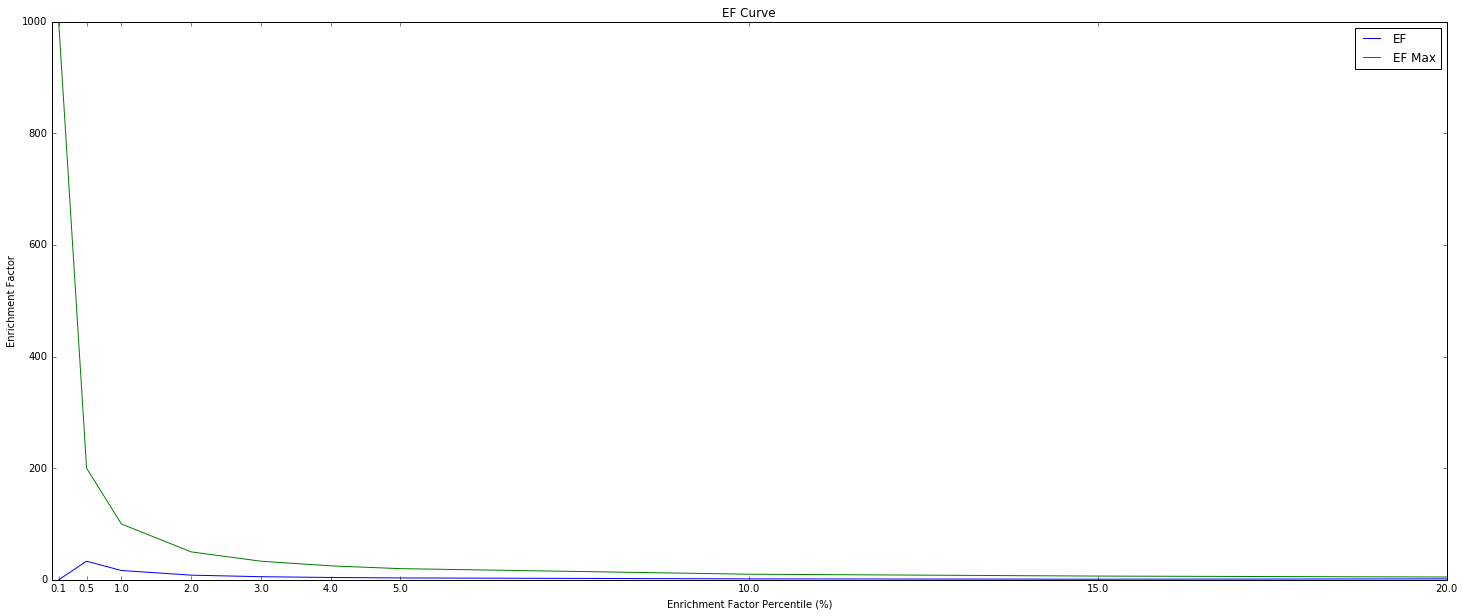

In [17]:
plot_EF_score_with_existing_model(X_test, y_test, PMTNN_weight_file)